In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 26.0 MB/s eta 0:00:00


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, concatenate, Activation, LeakyReLU,BatchNormalization,Conv2D,add
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam,SGD,Adagrad
from keras.models import Model, load_model
from keras.layers import Input,Dropout,add,BatchNormalization
import numpy as np
from tensorflow.keras.initializers import GlorotNormal,HeNormal,RandomNormal
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, UpSampling2D, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal,Orthogonal
from tensorflow.keras.regularizers import l2
from tensorflow_addons.layers import SpectralNormalization,InstanceNormalization
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
tf.keras.backend.clear_session()
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = InteractiveSession(config=ConfigProto(gpu_options=gpu_options))
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
/usr/local/lib/python3.9/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
FFHQ_DIR=r'data/image_dump'
FFHQ_read = open(FFHQ_DIR, "rb")
FFHQ_data = pickle.load(FFHQ_read)
np.random.shuffle(FFHQ_data)

In [ ]:
FFHQ_data.shape

(1000, 224, 224, 3)

In [ ]:
IMG_SIZE=128
def preprocess_image(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image= image.numpy().astype(np.float32)
    return image
new_image = (tf.cast(FFHQ_data, tf.float32) / 127.5)-1
new_image=preprocess_image(new_image)

(1000, 128, 128, 3)


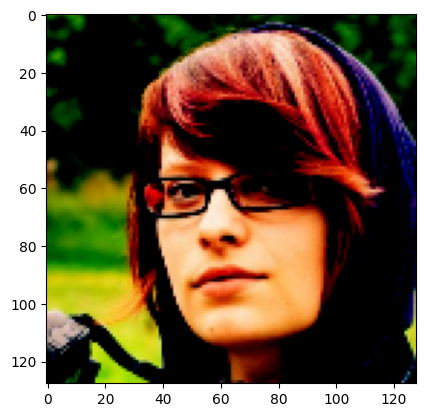

In [ ]:
plt.imshow(new_image[3])
print(new_image.shape)

In [ ]:

# def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
#     gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
#     gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
#     return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


# def get_box(lambda_value):
#     cut_rat = tf.math.sqrt(1.0 - lambda_value)

#     cut_w = IMG_SIZE * cut_rat  # rw
#     cut_w = tf.cast(cut_w, tf.int32)

#     cut_h = IMG_SIZE * cut_rat  # rh
#     cut_h = tf.cast(cut_h, tf.int32)

#     cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
#     cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

#     boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
#     boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
#     bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
#     bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

#     target_h = bby2 - boundaryy1
#     if target_h == 0:
#         target_h += 1

#     target_w = bbx2 - boundaryx1
#     if target_w == 0:
#         target_w += 1

#     return boundaryx1, boundaryy1, target_h, target_w


# def cutmix(train_ds_one, train_ds_two):
#     image1,image2 = train_ds_one, train_ds_two

#     alpha = [0.25]
#     beta = [0.25]

#     # Get a sample from the Beta distribution
#     lambda_value = sample_beta_distribution(1, alpha, beta)

#     # Define Lambda
#     lambda_value = lambda_value[0][0]

#     # Get the bounding box offsets, heights and widths
#     boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

#     # Get a patch from the second image (`image2`)
#     crop2 = tf.image.crop_to_bounding_box(
#         image2, boundaryy1, boundaryx1, target_h, target_w
#     )
#     # Pad the `image2` patch (`crop2`) with the same offset
#     image2 = tf.image.pad_to_bounding_box(
#         crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
#     )
#     # Get a patch from the first image (`image1`)
#     crop1 = tf.image.crop_to_bounding_box(
#         image1, boundaryy1, boundaryx1, target_h, target_w
#     )
#     # Pad the `image1` patch (`crop1`) with the same offset
#     img1 = tf.image.pad_to_bounding_box(
#         crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
#     )

#     # Modify the first image by subtracting the patch from `image1`
#     # (before applying the `image2` patch)
#     image1 = image1 - img1
#     # Add the modified `image1` and `image2`  together to get the CutMix image
#     image = image1 + image2

#     # Adjust Lambda in accordance to the pixel ration
#     lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
#     lambda_value = tf.cast(lambda_value, tf.float32)
#     return image

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
from keras.layers.serialization import activation
from tensorflow.python import training
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input,Dropout,add,BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import keras
import tensorflow as tf
class InstanceNormalization(tf.keras.layers.Layer):

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset
def make_generator_model():
    inputs = Input(shape=(100,))
    den1 = Dense(128*128*3)(inputs)
    den1 = Reshape((128,128, 3))(den1)

    conv1 = keras.layers.Conv2D(16, 4, activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal',use_bias=False,strides=2)(den1)

    conv2 = keras.layers.Conv2D(32, 4, activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal',use_bias=False)(conv1)
    conv2=BatchNormalization()(conv2)

    conv3 = keras.layers.Conv2D(64, 4, activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal',use_bias=False,strides=2)(conv2)
    conv3 = BatchNormalization()(conv3)

    up8 = keras.layers.Conv2DTranspose(32, 4,2, activation=tf.keras.layers.ReLU(), padding='same', kernel_initializer='he_normal',use_bias=False)(conv3)
    up8=Dropout(0.5)(up8)
    merge8 = keras.layers.concatenate([conv2, up8], axis=3)
    

    up9 = keras.layers.Conv2DTranspose(16, 4, activation=tf.keras.layers.ReLU(), padding='same', kernel_initializer='he_normal',use_bias=False)(merge8)
    up9=Dropout(0.5)(up9)
    merge9 = keras.layers.concatenate([conv1, up9], axis=3)

    conv9 = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,padding='same', kernel_initializer='he_normal',activation=tf.keras.layers.ReLU())(merge9)
    conv9=keras.layers.Conv2D(128, (4,4), padding='same')(conv9)
    conv9=LeakyReLU(alpha=0.2)(conv9)
    conv9=keras.layers.Conv2D(128, (4,4), padding='same')(conv9)
    conv9=LeakyReLU(alpha=0.2)(conv9)
    conv9=keras.layers.Conv2D(3, (7,7),activation='tanh', padding='same')(conv9)

    model = keras.models.Model(inputs=inputs, outputs=conv9)

    return model
 
# generator=make_generator_model()
# generator.summary()
# tf.keras.utils.plot_model(generator,show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 49152)        4964352     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 128, 128, 3)  0           ['dense[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   768         ['reshape[0][0]']                
                                                                                              

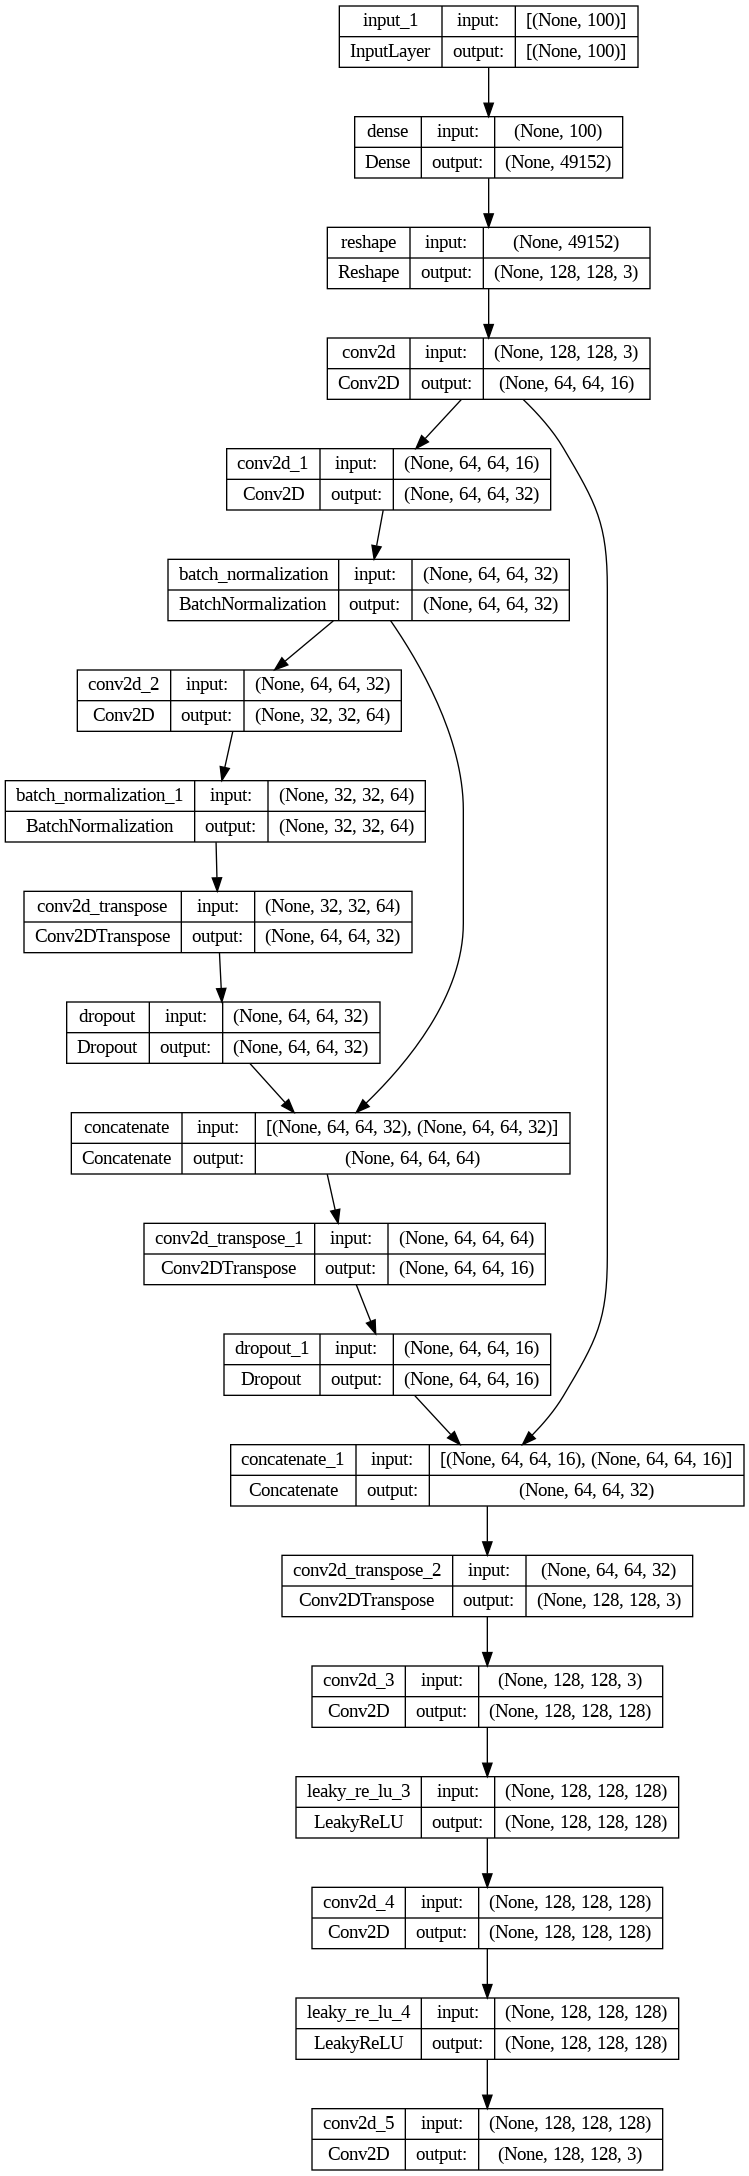

In [ ]:
generator=tf.keras.models.load_model('generator_model200.h5')
generator.summary()
tf.keras.utils.plot_model(generator,show_shapes=True)

In [ ]:
latent_dim=100
num_img=10
random_latent_vectors = tf.random.normal(shape=(100, latent_dim))
img=generator.predict(random_latent_vectors,batch_size=10,steps=1)
# img=tf.keras.backend.eval(img)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 10s 10s/step


(10, 128, 128, 3)


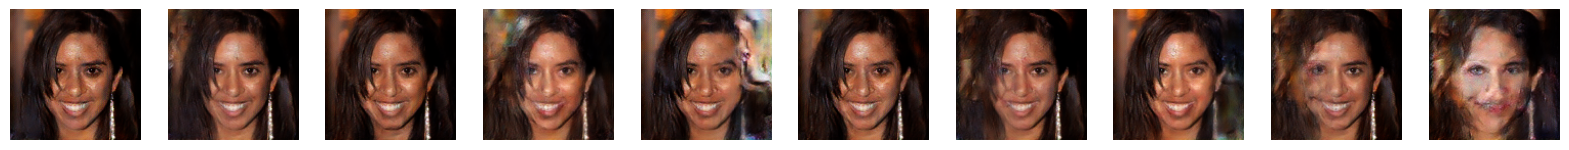

In [ ]:
# img=tf.keras.backend.eval(img)

print(img.shape)
# img = img.eval(session=tf.compat.v1.Session())
fig=plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(10,10,i + 1)
    image1 = tf.keras.preprocessing.image.array_to_img(np.array(img[i]))
    plt.imshow(image1)
    plt.axis('off')
plt.show()
# print(discriminator({'image':img}).numpy())

In [ ]:
def resnet_block(input,filter_size):
  conv=Conv2D(filter_size,(3,3),kernel_initializer=HeNormal(),padding='same')(input)
  conv=BatchNormalization()(conv)
  # conv=LeakyReLU()(conv)
  # conv=InstanceNormalization()(conv)
  conv=Dropout(0.4)(conv)
  conv=Conv2D(filter_size,(3,3),kernel_initializer=HeNormal(),padding='same')(conv)
  conv=BatchNormalization()(conv)
  # conv=LeakyReLU()(conv)
  # conv=InstanceNormalization()(conv)
  conv=Dropout(0.4)(conv)
  conv=add([input,conv])
  return conv
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def make_discriminator():
  model = Sequential()
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same', input_shape=(128,128,3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  # opt = Adam(lr=0.0002, beta_1=0.5)
  # model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

# discriminator=make_discriminator()
# discriminator.summary()
# tf.keras.utils.plot_model(discriminator,show_shapes=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       1

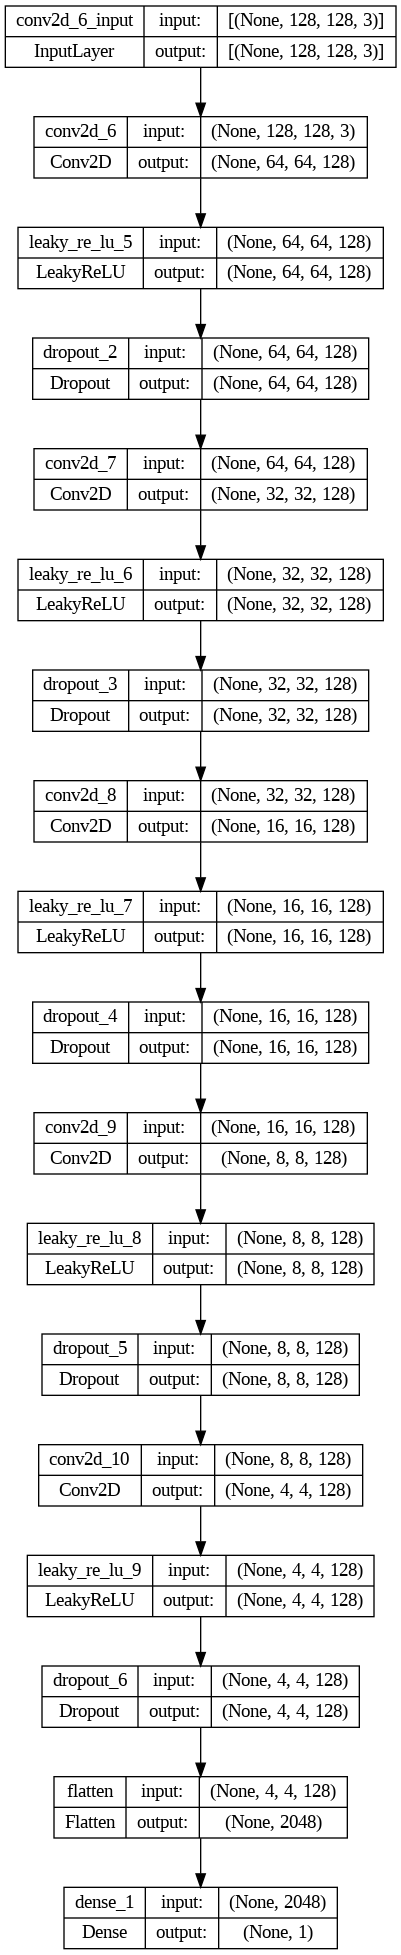

In [ ]:
discriminator=tf.keras.models.load_model('discriminator_model200.h5')
discriminator.summary()
tf.keras.utils.plot_model(discriminator,show_shapes=True)


In [ ]:
ypred_bottleneck=discriminator.predict(img)

1/1 [==============================] - 0s 282ms/step


In [ ]:
from keras.losses import BinaryCrossentropy
generator_optimizer = tf.keras.optimizers.Adam(0.00005)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
# encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
# decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)

generator_loss=BinaryCrossentropy(from_logits=True)
discriminator_loss=BinaryCrossentropy(from_logits=True)
# encoder_loss=BinaryCrossentropy(from_logits=True)
# decoder_loss=BinaryCrossentropy(from_logits=True)

# def hinge_loss(y_true, y_pred):
#     return tf.reduce_mean(tf.maximum(1.0 - y_true * y_pred, 0.0))

# def discriminator_loss(y_true, y_pred):
#     real_loss = hinge_loss(y_true, y_pred)
#     fake_loss = hinge_loss(-y_true, -y_pred)
#     return real_loss + fake_loss

# def generator_loss(_, y_pred):
#     return -tf.reduce_mean(y_pred)

# def discriminator_loss()
#         logits_real: tf.Tensor,
#         logits_fake: tf.Tensor,
#     ) -> tf.Tensor:
#         """
#         Computes the "hinge" discriminator loss given two
#         discriminator outputs, `logits_real` and `logits_fake`.
#         Cf. Miyato, https://arxiv.org/pdf/1802.05957.pdf,
#         equation 16.
#         """
#         L_D = tf.reduce_sum(tf.nn.relu(1.0 - logits_real)) \
#             + tf.reduce_sum(tf.nn.relu(1.0 + logits_fake))
#         return L_D * (1.0 / BATCH_SIZE)

# def generator_loss(
#     logits_fake: tf.Tensor,
# ) -> tf.Tensor:
#     """
#     Computes the "hinge" generator loss given one
#     discriminator output, `logits_fake`.
#     Cf. Miyato, https://arxiv.org/pdf/1802.05957.pdf,
#     equation 17.
#     """
#     L_G = -tf.reduce_sum(logits_fake)
#     return L_G * (1.0 / BATCH_SIZE)



In [ ]:
class GAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.generator=generator
    self.discriminator=discriminator

  def compile(self,generator_optimizer,discriminator_optimizer,*args,**kwargs):
    super().compile(*args,**kwargs)
    self.generator_optimizer=generator_optimizer
    self.discriminator_optimizer=discriminator_optimizer
    # self.encoder_optimizer=encoder_optimizer
    # self.decoder_optimizer=decoder_optimizer
    pass
  def train_step(self,images):
    # real_images=images
    noise=tf.random.normal((BATCH_SIZE,100))

    with tf.GradientTape() as g_tape,tf.GradientTape() as d_tape:
      generated_image=self.generator(noise,training=True)
      
      # train_ds_cmu=augumentation(images,generated_image)
      # tf.config.run_functions_eagerly(True)
      # augumented_images = train_ds_cmu.as_numpy_iterator()
      # augumented_images = np.concatenate([batch for batch in augumented_images], axis=0)

      # ypred_real_encoder,ypred_real_decoder=self.discriminator(images,training=True)
      # ypred_real_decoder=self.decoder(images,training=True)

      # ypred_fake_encoder,ypred_fake_decoder=self.discriminator(generated_image,training=True)
      # ypred_fake_decoder=self.decoder(generated_image,training=True)


      # ypred_gen_encoder,ypred_gen_decoder=self.discriminator(generated_image,training=False)
      # ypred_gen_decoder=self.decoder(generated_image,training=False)

      ypred_real_decoder=self.discriminator(images,training=True)
      ypred_fake_decoder=self.discriminator(generated_image,training=True)
      ypred_gen_decoder=self.discriminator(generated_image,training=False)


      # real_loss=discriminator_loss(tf.ones_like(ypred_real_encoder),ypred_real_encoder)+discriminator_loss(tf.ones_like(ypred_real_decoder),ypred_real_decoder)
      # fake_loss=discriminator_loss(tf.zeros_like(ypred_fake_encoder),ypred_fake_encoder)+discriminator_loss(tf.zeros_like(ypred_fake_decoder),ypred_fake_decoder)
      
      real_loss=discriminator_loss(tf.ones_like(ypred_real_decoder),ypred_real_decoder)
      fake_loss=discriminator_loss(tf.zeros_like(ypred_fake_decoder),ypred_fake_decoder)
      total_d_loss=(real_loss+fake_loss)

      # total_g_loss=generator_loss(tf.ones_like(ypred_gen_encoder),ypred_gen_encoder)+generator_loss(tf.ones_like(ypred_gen_decoder),ypred_gen_decoder)
      total_g_loss=(generator_loss(tf.ones_like(ypred_gen_decoder),ypred_gen_decoder))



    ggrad=g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    dgrad=d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)

    self.generator_optimizer.apply_gradients(zip(ggrad,self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))




    return {"d_loss:":total_d_loss,"g_loss:":total_g_loss}




In [ ]:
GAN_model=GAN(generator,discriminator)
GAN_model.compile(generator_optimizer,discriminator_optimizer)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
# reduce_lr_disc = ReduceLROnPlateau(monitor='d_loss:', factor=0.1, patience=3, min_lr=0.01)
# reduce_lr_gen = ReduceLROnPlateau(monitor='g_loss:', factor=0.1, patience=3, min_lr=0.01)
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=(100)):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        # d_image=self.model.discriminator(generated_images)
#         disc_images=self.model.discriminator(generated_images)
        generated_images *= 255
#         disc_images*=255
        generated_images.numpy()
#         disc_images.numpy()

        for i in range(self.num_img):
            gen_img = array_to_img(generated_images[i])
#             disc_img = array_to_img(disc_images[i])
            gen_img.save(os.path.join('t3images', f'generated_img_{epoch+1}_{i}.png'))
            # self.model.GAN_model.save('gan4.h5')
            self.model.generator.save('generator_model200.h5')
            self.model.discriminator.save('discriminator_model200.h5')
#             new_image1 = Image.new('RGB',(2*128, 128), (250,250,250))
#             new_image1.paste(gen_img,(0,0))
#             new_image1.paste(disc_img,(128,0))
#             new_image1.save(os.path.join('images2', f'generated_img_{epoch}_{i}.png'))

            
            
        def on_train_end(self, logs=None):
          self.model.save_pretrained('t3images')
          self.generator.save('generator_model200.h5')
          self.discriminator.save('discriminator_model200.h5')
        

In [ ]:
epochs=200
BATCH_SIZE=64
# Model_=GAN_model.fit(new_image,epochs=epochs,batch_size=BATCH_SIZE,callbacks=[ModelMonitor(),reduce_lr_disc,reduce_lr_gen])
Model_=GAN_model.fit(new_image,epochs=epochs,batch_size=BATCH_SIZE,callbacks=[ModelMonitor()])

Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - ETA: 0s - d_loss:: 0.1140 - g_loss:: 3.0439

16/16 [==============================] - 35s 1s/step - d_loss:: 0.1114 - g_loss:: 2.8975
Epoch 2/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1043 - g_loss:: 2.0551

16/16 [==============================] - 21s 1s/step - d_loss:: 0.1082 - g_loss:: 2.1612
Epoch 3/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0747 - g_loss:: 2.2070

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0877 - g_loss:: 2.1662
Epoch 4/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0740 - g_loss:: 1.4302

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0863 - g_loss:: 1.4442
Epoch 5/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0912 - g_loss:: 2.0307

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0870 - g_loss:: 1.9826
Epoch 6/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0805 - g_loss:: 2.1330

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0932 - g_loss:: 2.0834
Epoch 7/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0744 - g_loss:: 2.6356

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0791 - g_loss:: 2.8374
Epoch 8/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1052 - g_loss:: 4.5013

16/16 [==============================] - 22s 1s/step - d_loss:: 0.1052 - g_loss:: 4.6327
Epoch 9/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0996 - g_loss:: 3.4430

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0976 - g_loss:: 3.3909
Epoch 10/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0849 - g_loss:: 2.2440

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0844 - g_loss:: 2.1679
Epoch 11/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0645 - g_loss:: 2.2666

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0609 - g_loss:: 2.3041
Epoch 12/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0749 - g_loss:: 1.4575

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0796 - g_loss:: 1.4500
Epoch 13/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0624 - g_loss:: 1.7749

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0607 - g_loss:: 1.9738
Epoch 14/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0776 - g_loss:: 2.6749

16/16 [==============================] - 23s 1s/step - d_loss:: 0.0747 - g_loss:: 2.5887
Epoch 15/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0793 - g_loss:: 1.5499

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0756 - g_loss:: 1.5244
Epoch 16/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0654 - g_loss:: 1.4634

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0634 - g_loss:: 1.4136
Epoch 17/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0955 - g_loss:: 2.7531

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0909 - g_loss:: 2.7094
Epoch 18/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0848 - g_loss:: 2.9072

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0805 - g_loss:: 2.9061
Epoch 19/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0541 - g_loss:: 2.4774

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0521 - g_loss:: 2.3820
Epoch 20/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0603 - g_loss:: 1.7752

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0617 - g_loss:: 1.7092
Epoch 21/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0809 - g_loss:: 2.2679

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0869 - g_loss:: 2.2611
Epoch 22/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0986 - g_loss:: 2.9616

16/16 [==============================] - 22s 1s/step - d_loss:: 0.1088 - g_loss:: 3.1648
Epoch 23/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0876 - g_loss:: 3.7820

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0937 - g_loss:: 3.7806
Epoch 24/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0661 - g_loss:: 2.2958

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0624 - g_loss:: 2.3420
Epoch 25/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1239 - g_loss:: 4.7390

16/16 [==============================] - 22s 1s/step - d_loss:: 0.1215 - g_loss:: 4.8445
Epoch 26/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1864 - g_loss:: 4.9998

16/16 [==============================] - 22s 1s/step - d_loss:: 0.1783 - g_loss:: 4.8017
Epoch 27/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0772 - g_loss:: 2.5957

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0814 - g_loss:: 2.5414
Epoch 28/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1461 - g_loss:: 3.5400

16/16 [==============================] - 21s 1s/step - d_loss:: 0.1521 - g_loss:: 3.7342
Epoch 29/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0907 - g_loss:: 5.1359

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0906 - g_loss:: 5.0406
Epoch 30/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0493 - g_loss:: 2.3712

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0523 - g_loss:: 2.3814
Epoch 31/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0606 - g_loss:: 1.0318

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0573 - g_loss:: 1.0568
Epoch 32/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0890 - g_loss:: 1.4888

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0870 - g_loss:: 1.4499
Epoch 33/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0844 - g_loss:: 2.4848

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0795 - g_loss:: 2.6047
Epoch 34/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1061 - g_loss:: 3.4033

16/16 [==============================] - 21s 1s/step - d_loss:: 0.1329 - g_loss:: 3.5137
Epoch 35/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0629 - g_loss:: 1.7115

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0646 - g_loss:: 1.6835
Epoch 36/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0722 - g_loss:: 1.6488

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0857 - g_loss:: 1.6599
Epoch 37/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0654 - g_loss:: 1.6504

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0625 - g_loss:: 1.6314
Epoch 38/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0779 - g_loss:: 1.9193

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0736 - g_loss:: 1.9225
Epoch 39/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0565 - g_loss:: 1.1457

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0538 - g_loss:: 1.1858
Epoch 40/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0732 - g_loss:: 2.3224

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0690 - g_loss:: 2.5958
Epoch 41/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0937 - g_loss:: 3.9578

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0948 - g_loss:: 4.0092
Epoch 42/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0922 - g_loss:: 2.8950

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0871 - g_loss:: 2.9257
Epoch 43/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0673 - g_loss:: 2.7475

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0702 - g_loss:: 2.7464
Epoch 44/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0742 - g_loss:: 2.0279

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0703 - g_loss:: 2.0313
Epoch 45/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0742 - g_loss:: 2.0366

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0707 - g_loss:: 2.0699
Epoch 46/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0646 - g_loss:: 1.8606

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0617 - g_loss:: 1.8116
Epoch 47/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0614 - g_loss:: 1.7888

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0688 - g_loss:: 1.7307
Epoch 48/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0694 - g_loss:: 1.1740

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0665 - g_loss:: 1.1523
Epoch 49/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0872 - g_loss:: 2.1835

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0970 - g_loss:: 2.2177
Epoch 50/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0724 - g_loss:: 2.5770

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0747 - g_loss:: 2.7025
Epoch 51/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1006 - g_loss:: 3.7017

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0950 - g_loss:: 3.8453
Epoch 52/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1243 - g_loss:: 3.8086

16/16 [==============================] - 21s 1s/step - d_loss:: 0.1184 - g_loss:: 3.6947
Epoch 53/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0757 - g_loss:: 2.3585

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0807 - g_loss:: 2.5192
Epoch 54/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0877 - g_loss:: 2.7809

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0928 - g_loss:: 2.8097
Epoch 55/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0792 - g_loss:: 2.7814

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0853 - g_loss:: 2.8855
Epoch 56/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0856 - g_loss:: 1.8894

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0904 - g_loss:: 1.8585
Epoch 57/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0712 - g_loss:: 2.6514

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0670 - g_loss:: 2.8385
Epoch 58/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0932 - g_loss:: 3.3757

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0885 - g_loss:: 3.3308
Epoch 59/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0859 - g_loss:: 2.8624

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0810 - g_loss:: 2.9403
Epoch 60/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0978 - g_loss:: 3.3655

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0934 - g_loss:: 3.2920
Epoch 61/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0657 - g_loss:: 2.5276

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0649 - g_loss:: 2.5099
Epoch 62/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0830 - g_loss:: 1.9649

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0794 - g_loss:: 1.9332
Epoch 63/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0612 - g_loss:: 1.8603

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0586 - g_loss:: 1.8187
Epoch 64/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0662 - g_loss:: 1.2640

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0694 - g_loss:: 1.2649
Epoch 65/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0726 - g_loss:: 1.4038

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0687 - g_loss:: 1.4622
Epoch 66/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0838 - g_loss:: 2.9090

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0790 - g_loss:: 2.9760
Epoch 67/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0638 - g_loss:: 1.7759

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0609 - g_loss:: 1.7606
Epoch 68/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0597 - g_loss:: 1.3157

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0578 - g_loss:: 1.2735
Epoch 69/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0890 - g_loss:: 3.4180

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0860 - g_loss:: 3.2834
Epoch 70/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0701 - g_loss:: 2.0299

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0667 - g_loss:: 2.0495
Epoch 71/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0646 - g_loss:: 2.2297

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0662 - g_loss:: 2.1637
Epoch 72/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0822 - g_loss:: 3.3720

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0775 - g_loss:: 3.4271
Epoch 73/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0805 - g_loss:: 2.9719

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0760 - g_loss:: 3.0607
Epoch 74/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0685 - g_loss:: 3.3282

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0675 - g_loss:: 3.2245
Epoch 75/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0717 - g_loss:: 1.7535

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0784 - g_loss:: 1.7084
Epoch 76/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0776 - g_loss:: 1.6700

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0793 - g_loss:: 1.7073
Epoch 77/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0697 - g_loss:: 2.2039

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0658 - g_loss:: 2.2698
Epoch 78/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0829 - g_loss:: 2.3823

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0860 - g_loss:: 2.4004
Epoch 79/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0689 - g_loss:: 2.0374

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0651 - g_loss:: 2.1198
Epoch 80/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0846 - g_loss:: 2.5945

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0798 - g_loss:: 2.6663
Epoch 81/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0658 - g_loss:: 2.9985

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0654 - g_loss:: 2.8874
Epoch 82/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0723 - g_loss:: 1.7638

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0769 - g_loss:: 1.7119
Epoch 83/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0727 - g_loss:: 2.5987

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0686 - g_loss:: 2.6616
Epoch 84/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0714 - g_loss:: 1.8333

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0681 - g_loss:: 1.8121
Epoch 85/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0649 - g_loss:: 1.4330

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0623 - g_loss:: 1.4065
Epoch 86/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0700 - g_loss:: 1.0208

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0663 - g_loss:: 1.0594
Epoch 87/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0681 - g_loss:: 1.8157

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0644 - g_loss:: 1.8568
Epoch 88/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.1014 - g_loss:: 5.3088

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0965 - g_loss:: 5.1562
Epoch 89/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0751 - g_loss:: 3.0073

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0779 - g_loss:: 3.0863
Epoch 90/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0673 - g_loss:: 3.1028

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0640 - g_loss:: 3.1050
Epoch 91/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0743 - g_loss:: 2.7429

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0776 - g_loss:: 2.7810
Epoch 92/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0788 - g_loss:: 2.2787

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0742 - g_loss:: 2.4466
Epoch 93/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0964 - g_loss:: 3.9975

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0978 - g_loss:: 3.8650
Epoch 94/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0693 - g_loss:: 2.7944

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0659 - g_loss:: 2.7600
Epoch 95/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0690 - g_loss:: 1.6220

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0725 - g_loss:: 1.5823
Epoch 96/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0855 - g_loss:: 1.5049

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0875 - g_loss:: 1.4986
Epoch 97/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0791 - g_loss:: 1.6996

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0828 - g_loss:: 1.6515
Epoch 98/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0708 - g_loss:: 1.1268

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0682 - g_loss:: 1.0885
Epoch 99/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0836 - g_loss:: 1.6561

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0804 - g_loss:: 1.6073
Epoch 100/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0865 - g_loss:: 3.5119

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0862 - g_loss:: 3.4134
Epoch 101/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0713 - g_loss:: 2.2467

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0736 - g_loss:: 2.2461
Epoch 102/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0763 - g_loss:: 2.1000

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0726 - g_loss:: 2.1243
Epoch 103/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0732 - g_loss:: 2.0080

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0700 - g_loss:: 1.9716
Epoch 104/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0753 - g_loss:: 1.9284

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0763 - g_loss:: 1.8926
Epoch 105/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0717 - g_loss:: 1.6733

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0734 - g_loss:: 1.6750
Epoch 106/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0692 - g_loss:: 1.9722

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0659 - g_loss:: 1.9569
Epoch 107/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0813 - g_loss:: 1.5618

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0779 - g_loss:: 1.5316
Epoch 108/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0637 - g_loss:: 2.0572

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0665 - g_loss:: 2.0224
Epoch 109/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0691 - g_loss:: 1.3358

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0663 - g_loss:: 1.3238
Epoch 110/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0641 - g_loss:: 1.5748

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0611 - g_loss:: 1.5827
Epoch 111/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0782 - g_loss:: 2.8109

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0829 - g_loss:: 2.7021
Epoch 112/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0778 - g_loss:: 3.1913

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0754 - g_loss:: 3.1500
Epoch 113/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0832 - g_loss:: 3.3651

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0847 - g_loss:: 3.3479
Epoch 114/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0670 - g_loss:: 2.6077

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0634 - g_loss:: 2.6570
Epoch 115/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0756 - g_loss:: 2.0231

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0777 - g_loss:: 1.9960
Epoch 116/200
15/16 [===========================>..] - ETA: 1s - d_loss:: 0.0697 - g_loss:: 0.9739

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0633 - g_loss:: 0.9391
Epoch 117/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0865 - g_loss:: 2.0982

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0816 - g_loss:: 2.2106
Epoch 118/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0809 - g_loss:: 2.4522

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0843 - g_loss:: 2.4726
Epoch 119/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0690 - g_loss:: 2.4139

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0656 - g_loss:: 2.3921
Epoch 120/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0757 - g_loss:: 2.3374

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0779 - g_loss:: 2.3536
Epoch 121/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0803 - g_loss:: 2.5760

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0757 - g_loss:: 2.6990
Epoch 122/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0812 - g_loss:: 2.7578

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0820 - g_loss:: 2.7322
Epoch 123/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0745 - g_loss:: 2.1439

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0757 - g_loss:: 2.1018
Epoch 124/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0730 - g_loss:: 2.0248

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0700 - g_loss:: 1.9865
Epoch 125/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0805 - g_loss:: 2.1851

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0811 - g_loss:: 2.1556
Epoch 126/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0834 - g_loss:: 2.4973

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0988 - g_loss:: 2.4950
Epoch 127/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0787 - g_loss:: 2.5784

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0816 - g_loss:: 2.5482
Epoch 128/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0856 - g_loss:: 2.7032

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0907 - g_loss:: 2.7564
Epoch 129/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0827 - g_loss:: 2.7101

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0866 - g_loss:: 2.7752
Epoch 130/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0779 - g_loss:: 2.9587

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0743 - g_loss:: 2.9484
Epoch 131/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0745 - g_loss:: 2.8071

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0753 - g_loss:: 2.7962
Epoch 132/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0782 - g_loss:: 2.8265

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0844 - g_loss:: 2.7869
Epoch 133/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0832 - g_loss:: 2.5842

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0840 - g_loss:: 2.5196
Epoch 134/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0828 - g_loss:: 3.0935

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0784 - g_loss:: 3.1033
Epoch 135/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0771 - g_loss:: 2.3844

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0729 - g_loss:: 2.4778
Epoch 136/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0821 - g_loss:: 3.0277

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0782 - g_loss:: 3.0181
Epoch 137/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0726 - g_loss:: 2.9718

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0691 - g_loss:: 2.9523
Epoch 138/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0796 - g_loss:: 2.2650

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0819 - g_loss:: 2.2385
Epoch 139/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0730 - g_loss:: 1.9429

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0699 - g_loss:: 1.9137
Epoch 140/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0784 - g_loss:: 2.5245

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0742 - g_loss:: 2.5561
Epoch 141/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0723 - g_loss:: 2.2402

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0686 - g_loss:: 2.2735
Epoch 142/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0747 - g_loss:: 2.3284

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0778 - g_loss:: 2.2761
Epoch 143/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0644 - g_loss:: 1.7193

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0617 - g_loss:: 1.6902
Epoch 144/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0729 - g_loss:: 2.3555

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0689 - g_loss:: 2.4401
Epoch 145/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0793 - g_loss:: 2.4292

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0883 - g_loss:: 2.4534
Epoch 146/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0655 - g_loss:: 2.2746

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0683 - g_loss:: 2.3462
Epoch 147/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0785 - g_loss:: 2.0151

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0744 - g_loss:: 2.0829
Epoch 148/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0780 - g_loss:: 2.9996

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0740 - g_loss:: 3.0108
Epoch 149/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0681 - g_loss:: 3.1066

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0651 - g_loss:: 3.0779
Epoch 150/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0776 - g_loss:: 3.1491

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0814 - g_loss:: 3.0791
Epoch 151/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0695 - g_loss:: 2.6670

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0661 - g_loss:: 2.6650
Epoch 152/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0793 - g_loss:: 2.4647

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0822 - g_loss:: 2.4235
Epoch 153/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0903 - g_loss:: 3.1711

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0954 - g_loss:: 3.2617
Epoch 154/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0837 - g_loss:: 3.2052

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0882 - g_loss:: 3.1988
Epoch 155/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0744 - g_loss:: 2.4855

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0768 - g_loss:: 2.5242
Epoch 156/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0725 - g_loss:: 2.2620

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0687 - g_loss:: 2.3133
Epoch 157/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0778 - g_loss:: 2.9768

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0748 - g_loss:: 2.9161
Epoch 158/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0745 - g_loss:: 3.2585

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0761 - g_loss:: 3.2258
Epoch 159/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0717 - g_loss:: 2.7507

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0687 - g_loss:: 2.7372
Epoch 160/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0682 - g_loss:: 2.7541

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0646 - g_loss:: 2.7929
Epoch 161/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0822 - g_loss:: 2.9755

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0849 - g_loss:: 2.9438
Epoch 162/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0780 - g_loss:: 2.7094

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0754 - g_loss:: 2.6458
Epoch 163/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0783 - g_loss:: 2.6119

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0809 - g_loss:: 2.6131
Epoch 164/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0714 - g_loss:: 2.3040

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0677 - g_loss:: 2.3120
Epoch 165/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0852 - g_loss:: 2.1780

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0896 - g_loss:: 2.2045
Epoch 166/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0712 - g_loss:: 2.6781

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0679 - g_loss:: 2.6767
Epoch 167/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0816 - g_loss:: 2.9305

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0846 - g_loss:: 2.8944
Epoch 168/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0686 - g_loss:: 2.0290

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0653 - g_loss:: 2.0158
Epoch 169/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0833 - g_loss:: 2.1883

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0787 - g_loss:: 2.2783
Epoch 170/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0735 - g_loss:: 3.3977

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0701 - g_loss:: 3.4565
Epoch 171/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0788 - g_loss:: 3.0129

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0834 - g_loss:: 2.9695
Epoch 172/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0757 - g_loss:: 2.3853

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0840 - g_loss:: 2.3733
Epoch 173/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0756 - g_loss:: 2.7366

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0808 - g_loss:: 2.8668
Epoch 174/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0778 - g_loss:: 3.8595

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0754 - g_loss:: 3.7801
Epoch 175/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0802 - g_loss:: 3.7623

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0861 - g_loss:: 3.7288
Epoch 176/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0839 - g_loss:: 3.3179

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0875 - g_loss:: 3.3092
Epoch 177/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0767 - g_loss:: 2.7048

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0784 - g_loss:: 2.6802
Epoch 178/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0708 - g_loss:: 2.7924

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0670 - g_loss:: 2.8535
Epoch 179/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0795 - g_loss:: 3.1211

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0810 - g_loss:: 3.1466
Epoch 180/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0781 - g_loss:: 3.2763

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0747 - g_loss:: 3.2395
Epoch 181/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0767 - g_loss:: 2.9876

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0737 - g_loss:: 2.9527
Epoch 182/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0727 - g_loss:: 2.9998

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0686 - g_loss:: 3.0932
Epoch 183/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0781 - g_loss:: 3.2175

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0746 - g_loss:: 3.1941
Epoch 184/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0774 - g_loss:: 3.3048

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0731 - g_loss:: 3.3570
Epoch 185/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0730 - g_loss:: 3.2515

16/16 [==============================] - 22s 1s/step - d_loss:: 0.0742 - g_loss:: 3.1764
Epoch 186/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0743 - g_loss:: 2.6640

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0706 - g_loss:: 2.6689
Epoch 187/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0754 - g_loss:: 2.9823

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0719 - g_loss:: 2.9773
Epoch 188/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0717 - g_loss:: 2.9207

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0679 - g_loss:: 2.9718
Epoch 189/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0803 - g_loss:: 2.8375

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0841 - g_loss:: 2.8386
Epoch 190/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0743 - g_loss:: 2.5601

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0703 - g_loss:: 2.6083
Epoch 191/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0724 - g_loss:: 2.6782

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0686 - g_loss:: 2.6916
Epoch 192/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0801 - g_loss:: 2.8868

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0823 - g_loss:: 2.8922
Epoch 193/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0746 - g_loss:: 2.6126

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0773 - g_loss:: 2.6296
Epoch 194/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0768 - g_loss:: 2.7936

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0730 - g_loss:: 2.7867
Epoch 195/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0764 - g_loss:: 2.8645

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0786 - g_loss:: 2.8890
Epoch 196/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0803 - g_loss:: 3.7682

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0861 - g_loss:: 3.7323
Epoch 197/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0759 - g_loss:: 3.4330

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0833 - g_loss:: 3.4339
Epoch 198/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0709 - g_loss:: 2.8857

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0713 - g_loss:: 2.8937
Epoch 199/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0771 - g_loss:: 2.6162

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0806 - g_loss:: 2.6181
Epoch 200/200
16/16 [==============================] - ETA: 0s - d_loss:: 0.0788 - g_loss:: 3.0639

16/16 [==============================] - 21s 1s/step - d_loss:: 0.0749 - g_loss:: 3.0720


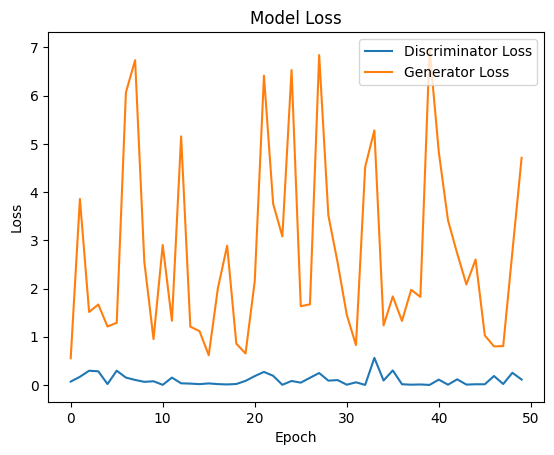

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Model_.history['d_loss:'][:50])
plt.plot(Model_.history['g_loss:'][:50])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()